In [1]:
import yfinance as yf
import requests
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import argrelextrema

In [2]:
def search_stock_symbol(company_name):
    # Alpha Vantage API URL for SYMBOL_SEARCH
    url = f'https://www.alphavantage.co/query?function=SYMBOL_SEARCH&keywords={company_name}&apikey=Y9DN79N2PBBK2X1O'
    
    # Send request to Alpha Vantage API
    response = requests.get(url)
    data = response.json()
    
    # Extract and print best matches
    if 'bestMatches' in data:
        match = data['bestMatches'][0]
        symbol = match['1. symbol']
        name = match['2. name']
        
        return symbol
    else:
        
        raise ValueError("No such company found")

In [3]:
def symbol_changes(symbol):
    symbol = symbol[:-3]
    symbol += "NS"
    
    return symbol

In [4]:
def pe_and_market_cap(symbol):
    
    comp = yf.Ticker(symbol)
    all_info = comp.info
    share_price = all_info['currentPrice']
    no_shares = all_info['sharesOutstanding']
    eps = all_info['trailingEps']
    
    market_cap = share_price * no_shares
    pe = market_cap/ (eps * no_shares)
    
    if market_cap < (5000 * (10 **7)):
        Id ='s' #Small Cap

    elif (5000 * (10 ** 7)) < market_cap < 20000 * (10 ** 7):
        Id ='m' #Middle Cap

    else:
           Id ='l' #Large Cap
    
    if Id == 'l':
        id2 = 1
        
    else:
        id2 = 0
    
    return market_cap, pe, id2

In [5]:
def macd(data):
    
    ma12 = data['Close'].ewm(span=12, adjust=False).mean()
    ma26 = data['Close'].ewm(span=26, adjust=False).mean()
    macd = ma12 - ma26
    sl = macd.ewm(span=9, adjust=False).mean()
    
    histo = macd - sl
    
    data["MACD"] = macd
    data['Signal Line'] = sl
    data['Histogram'] = histo
    
    data['Signal'] = np.where((data['MACD'] > data['Signal Line']) & 
                              (data['MACD'].shift(1) <= data['Signal Line'].shift(1)), 1, 0)
    
    data['Signal'] = np.where((data['MACD'] < data['Signal Line']) & 
                              (data['MACD'].shift(1) >= data['Signal Line'].shift(1)), -1, data['Signal'])
    
    # Creating a column for prediction (Buy or Sell)
    data['Prediction'] = data['Signal'].apply(lambda x: 'Buy' if x == 1 else ('Sell' if x == -1 else 'Hold'))
    
    return data[['Close', 'MACD', 'Signal Line', 'Histogram', 'Prediction']]

In [81]:
def rsi(data, window=14):
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    # Calculate initial average gains and losses
    avg_gain = gain[:window].mean()
    avg_loss = loss[:window].mean()
    
    # Initialize RSI values
    rsi_values = []
    
    # Iterate through the rest of the data
    for i in range(window, len(data)):
        avg_gain = (avg_gain * (window - 1) + gain.iloc[i]) / window
        avg_loss = (avg_loss * (window - 1) + loss.iloc[i]) / window
        
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        
        rsi_values.append(rsi)
    
    # Add RSI column to the DataFrame
    data['RSI'] = pd.Series(rsi_values, index=data.index[window:])
    
    return data[window:]

In [79]:
b = rsi(data)

In [80]:
b.iloc[-1]['RSI']

46.177635734140885

In [7]:
# # Not giving the right answer
# def lifetime_high(company_name):
    
#     symbol = inp(company_name)
#     comp = yf.Ticker(symbol)
#     data = comp.history(period='1y', interval='1d')
    
#     return round(data['High'].max(), 3)

In [8]:
def fibonacci_retracement(data):
    
    close_prices = data['Close'].values

    # Identify local maxima and minima
    n = 5 
    local_max = argrelextrema(close_prices, np.greater, order=n)[0]
    local_min = argrelextrema(close_prices, np.less, order=n)[0]

    # Identify the latest trend
    if len(local_max) > 0 and len(local_min) > 0:
        last_extreme = max(local_max[-1], local_min[-1])
        if last_extreme == local_max[-1]:
            trend = "downtrend"
            high_price = close_prices[last_extreme]
            low_price = np.min(close_prices[last_extreme:])
        else:
            trend = "uptrend"
            low_price = close_prices[last_extreme]
            high_price = np.max(close_prices[last_extreme:])
    else:
        # If no local extrema found, use the entire dataset
        trend = "uptrend" if close_prices[-1] > close_prices[0] else "downtrend"
        high_price = np.max(close_prices)
        low_price = np.min(close_prices)

    # Calculate Fibonacci levels
    diff = high_price - low_price
    retracement_levels = {
            "23.6%": high_price - 0.236 * diff if trend == "uptrend" else low_price + 0.236 * diff,
            "38.2%": high_price - 0.382 * diff if trend == "uptrend" else low_price + 0.382 * diff,
            "50%": high_price - 0.500 * diff if trend == "uptrend" else low_price + 0.500 * diff,
            "61.8%": high_price - 0.618 * diff if trend == "uptrend" else low_price + 0.618 * diff,
            "78.6%": high_price - 0.786 * diff if trend == "uptrend" else low_price + 0.786 * diff
        }

    # Calculate Fibonacci extension levels
    extension_levels = {
        "123.6%": high_price + 0.236 * diff,
        "138.2%": high_price + 0.382 * diff,
        "150%": high_price + 0.500 * diff,
        "161.8%": high_price + 0.618 * diff,
        "200%": high_price + diff,
    }

    return {
        "trend": trend,
        "prices": {
            "high_price": high_price,
            "low_price": low_price
        },
        "retracement_levels": retracement_levels,
        "extension_levels": extension_levels,
    }

In [42]:
def fib_insight(current_price, levels, trend):
    insights = []
    weight = 0

    if trend == 'uptrend':
        insights.append("Trend: Uptrend")
        for level_name, level_value in levels['extension'].items():
            if current_price <= level_value * 1.01 and current_price >= level_value * 0.99:  # Price is 1% away from the level
                insights.append(f"The current price is near the {level_name} extension level ({round(level_value, 2)}), indicating potential resistance. Hence SELL")
                weight -= 1  # Resistance

            # Further weight adjustments needs to be added here based on how far the price is from the level
            
            elif current_price > level_value:  # Price above the level
                weight += 1  # Strengthening bullish sentiment

    elif trend == 'downtrend':
        insights.append("Trend: Downtrend")
        for level_name, level_value in levels['retracement'].items():
            if current_price <= level_value * 1.01 and current_price >= level_value * 0.99:  # Price is 1% away from the level
                insights.append(f"The current price is near the {level_name} retracement level ({round(level_value, 2)}), indicating potential support. Hence BUY")
                weight += 1  # Support

            # Further weight adjustments needs to be added here based on how far the price is from the level
            
            elif current_price < level_value:  # Price below the level
                weight -= 1  # Weakening bullish sentiment

    return insights, weight

In [33]:
def visualise_fib(d, data):
    high = d["prices"]['high_price']
    low = d["prices"]['low_price']
    trend = d["trend"]
    
    # Retracement levels
    retracement_levels = d['retracement_levels']
    
    # Extension levels
    extension_levels = d['extension_levels']
    
    # Plot settings
    plt.figure(figsize=(16, 10))
    plt.plot(data['Close'], label='Close Price', linewidth=2)

    # Highlight the trend
    trend_start_date = data.index[data['Close'] == low][0]
    trend_end_date = data.index[data['Close'] == high][0]
    
    plt.axvspan(trend_start_date, trend_end_date, color='yellow', alpha=0.3, label='Trend')

    # Colors for Fibonacci levels
    colors = plt.cm.rainbow(np.linspace(0, 1, len(retracement_levels) + len(extension_levels)))

    # Plot and annotate Fibonacci retracement levels
    for i, (label, level) in enumerate(retracement_levels.items()):
        color = colors[i]
        plt.axhline(level, linestyle='--', alpha=0.7, color=color, linewidth=1.5)
        plt.text(data.index[-1], level, f'{label} ({round(level, 2)})', 
                 color=color, va='center', ha='left', fontweight='bold',
                 bbox=dict(facecolor='white', edgecolor=color, alpha=0.8, boxstyle='round,pad=0.5'))

    # Plot and annotate Fibonacci extension levels
    for i, (label, level) in enumerate(extension_levels.items()):
        color = colors[i + len(retracement_levels)]
        plt.axhline(level, linestyle=':', alpha=0.7, color=color, linewidth=1.5)
        plt.text(data.index[-1], level, f'{label} ({round(level, 2)})', 
                 color=color, va='center', ha='left', fontweight='bold',
                 bbox=dict(facecolor='white', edgecolor=color, alpha=0.8, boxstyle='round,pad=0.5'))

    # Set title and labels
    plt.title('Fibonacci Retracement and Extension Levels', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    
    # Format x-axis to display months in 'Aug 2024' format
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    
    # Limit the x-axis to the last 6 months (optional, adjust as needed)
    extra_days = pd.Timedelta(days=20)
    plt.xlim(data.index[-180], data.index[-1]+extra_days)  

    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    
    plt.tight_layout()
    plt.show()
    
    # Print Fibonacci levels
    print("Retracement Levels:")
    for label, level in retracement_levels.items():
        print(f"{label} level: {round(level, 2)}")
    
    print('\nExtension Levels:')
    for label, level in extension_levels.items():
        print(f"{label} level: {round(level, 2)}")

In [45]:
comp = yf.Ticker('HINDCOPPER.NS')
data = comp.history(period='1y', interval='1d')

In [47]:
share_price

340.25

In [46]:
info = comp.info
share_price = info['currentPrice']

In [11]:
def visualise_macd(data):
    fig, ax1 = plt.subplots(1, figsize=(12,8))
    ax1.plot(data.index, data['MACD'], label='MACD', color='blue', linewidth=1.5)
    ax1.plot(data.index, data['Signal Line'], label='Signal Line', color='red', linestyle='--', linewidth=1.5)
    ax1.bar(data.index, data['MACD'] - data['Signal Line'], color='gray', alpha=0.5, label='MACD Histogram')
    ax1.legend(loc='upper left')
    
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax1.set_title("MACD")

In [12]:
def visualise_rsi(data):
    
    fig, ax2 = plt.subplots(1, figsize=(12,8))
    ax2.plot(data.index, data['RSI'], label='RSI', color='green', linewidth=1.5)
    ax2.axhline(70, linestyle='--', alpha=0.5, color='red')  # Overbought threshold
    ax2.axhline(30, linestyle='--', alpha=0.5, color='blue')  # Oversold threshold
    ax2.legend(loc='upper left')
    
    ax2.xaxis.set_major_locator(mdates.MonthLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax2.set_title("RSI")

Enter a name: state bank of india

Buy stocks of State Bank Of India

The P/E ratio is 10.43, which is below 20, hence BUY

MACD and signal are above 0, hence HOLD/SELL

RSI value is 40.404, suggesting it is under-bought, hence BUY


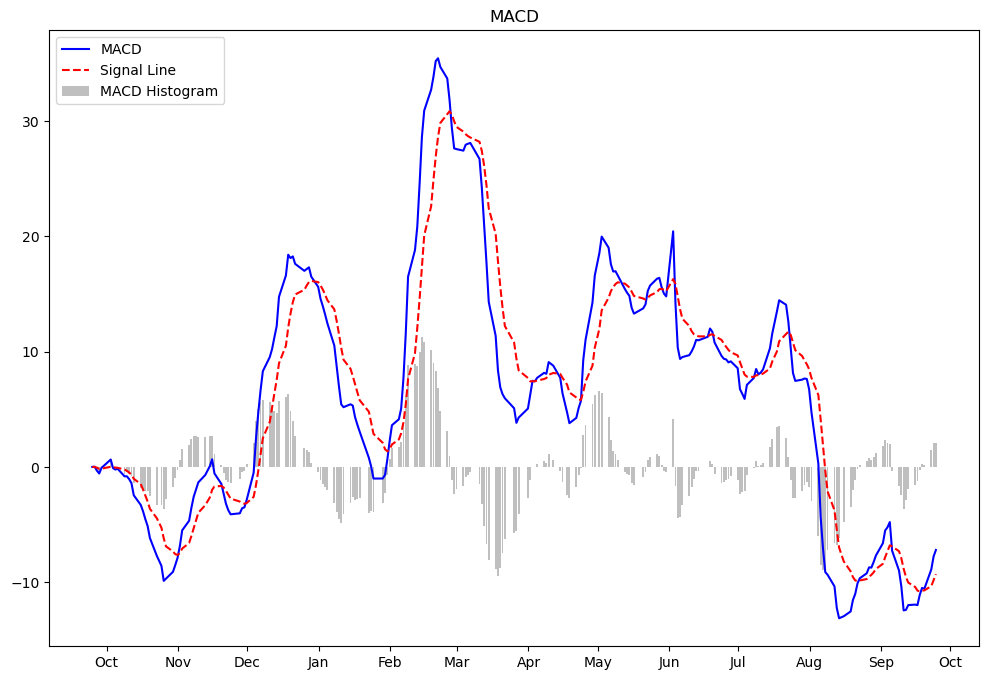

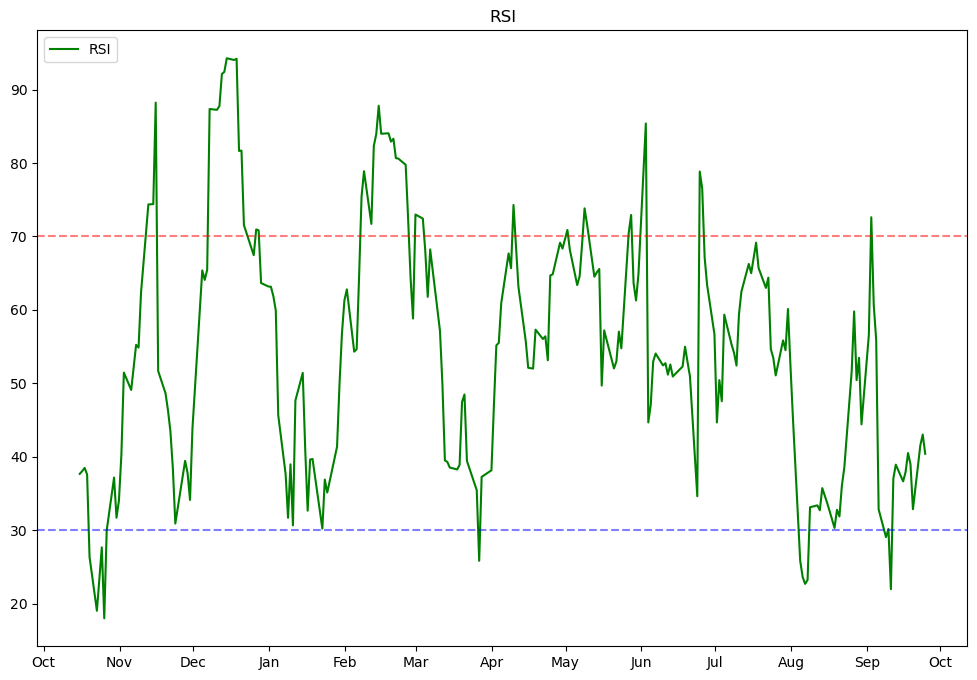

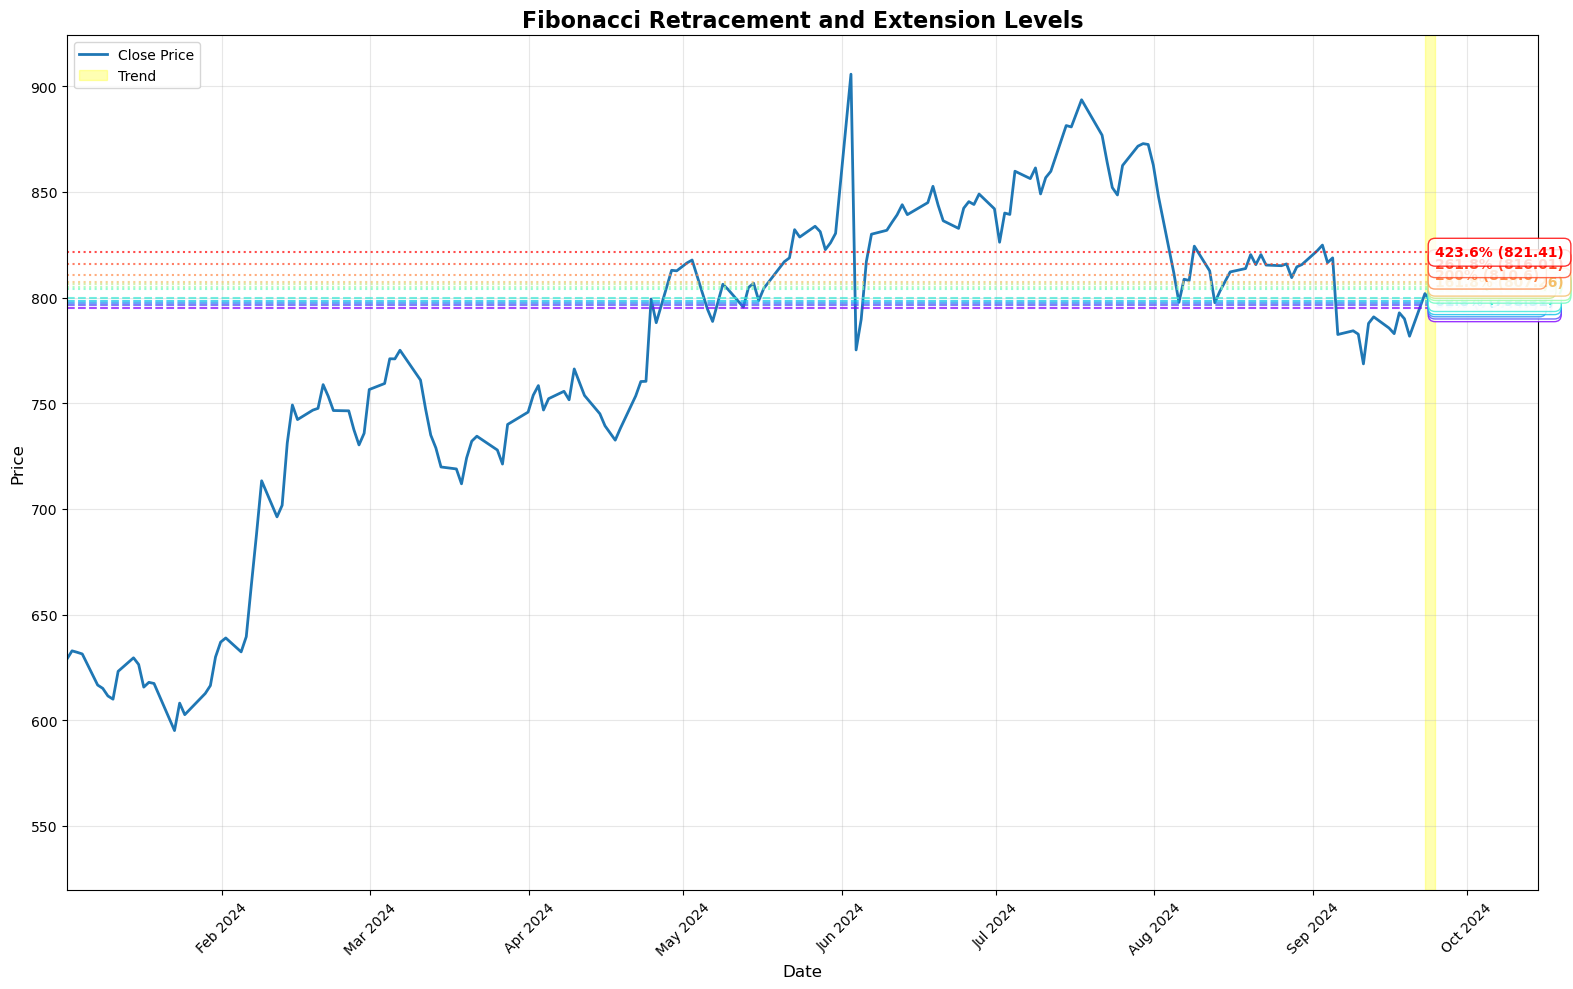

Retracement Levels:
23.6% level: 795.16
38.2% level: 796.44
50% level: 797.47
61.8% level: 798.51
78.6% level: 799.98

Extension Levels:
123.6% level: 803.91
138.2% level: 805.19
150% level: 806.22
161.8% level: 807.26
200% level: 810.6
261.8% level: 816.01
423.6% level: 821.41

Trend: Downtrend

The current price is near the 23.6% retracement level (795.16), indicating potential support. Hence BUY

Market Cap of State Bank Of India: 707810.78 Crores


In [49]:
#INPUT
name = input('Enter a name: ')

# PREPROCESSING THE NAME
symbol = search_stock_symbol(name)
symbol = symbol_changes(symbol)

# API CALL
comp = yf.Ticker(symbol)
data = comp.history(period='1y', interval='1d')

weights = {
    'pe': 0.4,
    'rsi': 0.3,
    'macd': 0.3,
    'fib': 0.3
}

# PE RATIO AND CAP ID
info = pe_and_market_cap(symbol)

if info[2] != 1:
    print('The company is not large cap')
    
else:
    pe = info[1]
    
    if pe <= 20:
        pe_score = 1  # Buy
        pe_response = f'The P/E ratio is {round(pe,2)}, which is below 20, hence BUY'
    
    else:
        pe_score = -1  # Sell
        pe_response = f'The P/E ratio is {round(pe,2)}, which is above 20, hence SELL'
        
        
    # RSI
    r = rsi(data)
    rsi_value = r['RSI']
    
    
    if 70 > rsi_value.iloc[-1] > 50:
        rsi_score = -0.5  # Mild Sell
        rsi_response = f'RSI value is {round(rsi_value.iloc[-1],3)}, suggesting the stock may be over-bought, hence SELL'
    
    elif 50 > rsi_value.iloc[-1] > 30:
        rsi_score = 0.5  # Mild Buy
        rsi_response = f'RSI value is {round(rsi_value.iloc[-1],3)}, suggesting it is under-bought, hence BUY'
    
    elif rsi_value.iloc[-1] > 70:
        rsi_score = -1  # Strong Sell
        rsi_response = f'RSI value is {round(rsi_value.iloc[-1],3)}, suggesting it is overbought, hence SELL'
    
    elif rsi_value.iloc[-1] < 30:
        rsi_score = 1  # Strong Buy
        rsi_response = f'RSI value is {round(rsi_value.iloc[-1],3)}, suggesting it is oversold, hence BUY'
    
    # MACD
    ma = macd(data)
    result = ma[-1:]
    
    pred = ma['Prediction']
    
    if pred.iloc[-1] == 'Buy':
        macd_score = 1  # Buy
        macd_response = f'The MACD line is cutting from above, hence BUY'
        
    elif pred.iloc[-1] == 'Sell':
        macd_score = -1  # Sell
        macd_response = f'The MACD line is cutting from below, hence SELL'
        
    else:
        val = ma['Histogram']
        
        if val.iloc[-1] < 0:
            macd_score = 0  # Hold
            macd_response = f"MACD and signal are below 0, hence HOLD/BUY"
            
        else:
            macd_score = 0  # Hold
            macd_response = f"MACD and signal are above 0, hence HOLD/SELL"
                   
        
    # Fibonacci Retracement
    fib = fibonacci_retracement(data)
    
    current_price = data['Close'].iloc[-1]
    trend = fib['trend']
    
    levels = dict()
    levels['retracement'] = fib['retracement_levels']
    levels ['extension'] = fib['extension_levels'] 
    
    
    fib_response, fib_score = fib_insight(current_price=current_price, trend=trend, levels=levels)
            

final_score = (pe_score * weights['pe']) + (rsi_score * weights['rsi']) + (macd_score * weights['macd']) + (fib_score * weights['fib'])

# Decision based on final score
if final_score > 0:
    print(f'\nBuy stocks of {name.title()}')
else:
    print(f'\nSell your stocks of {name.title()}')
    
print('\n' + pe_response)
    
visualise_macd(ma)
print('\n' + macd_response)
visualise_rsi(r)
print('\n' + rsi_response)
visualise_fib(fib, data)
print('\n' + fib_response[0])
print('\n' + fib_response[1])
print(f'\nMarket Cap of {name.title()}: {round(info[0] / (10 ** 7) , 2)} Crores')

In [44]:
symbol

'HINDCOPPER.NS'

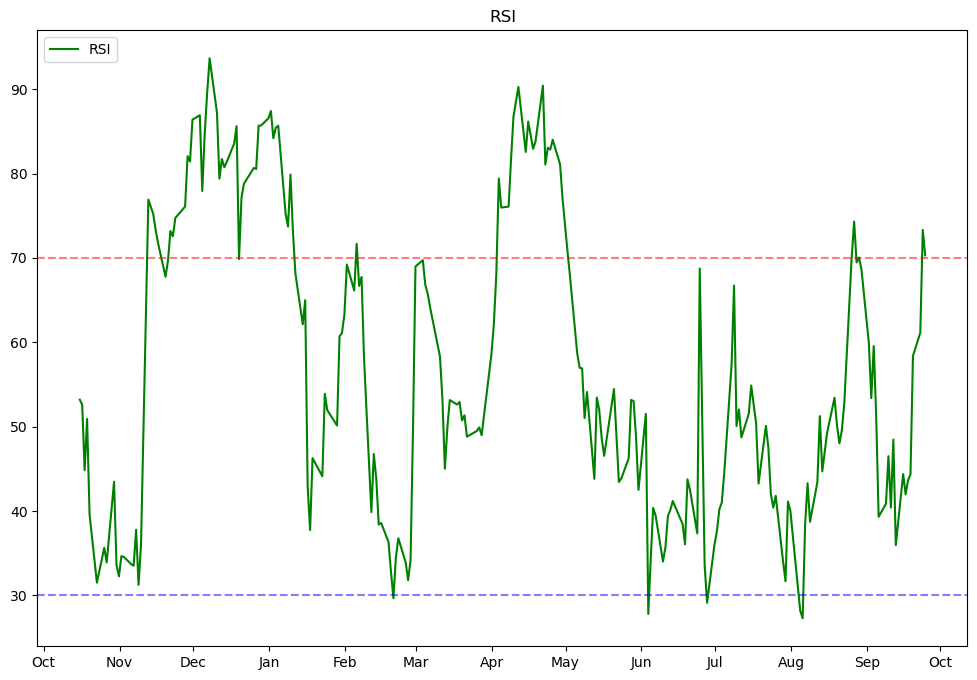

In [48]:
visualise_rsi(r)